In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Загрузим ваш датасет
data = pd.read_csv("dataset.csv")

# Преобразуем столбец времени в datetime, учитывая формат данных
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%d %H:%M:%S')

# Добавим ранее созданные признаки и метки
# 1. Длина пакета (Length)
data['Short_Packet'] = data['Length'] < 50
data['Long_Packet'] = data['Length'] > 1500

# 2. Частота запросов (Time)
time_window = '1T'  # 1 минута

# Создадим новый столбец для округленного времени до минуты
data['Time_Rounded'] = data['Time'].dt.floor(time_window)

# Подсчитаем количество пакетов от одного источника и к одному получателю за 1 минуту
data['Count_Same_Source'] = data.groupby(['Source', 'Time_Rounded'])['Time'].transform('count')
data['Count_Same_Destination'] = data.groupby(['Destination', 'Time_Rounded'])['Time'].transform('count')

# 3. Содержимое поля Info
data['Info'] = data['Info'].fillna('')  # Заполним пропущенные значения пустыми строками
suspicious_tlds = ['.xyz', '.top', '.info', '.club', '.work']
data['Suspicious_Info'] = data['Info'].apply(lambda x: any(tld in x for tld in suspicious_tlds))

# 4. Протокол (Protocol)
suspicious_protocols = ['LDAP', 'SMTP', 'ICMP', 'ARP', 'TFTP', 'HTTP', 'HTTPS', 'SMB', 'RDP', 'Telnet']
data['Suspicious_Protocol'] = data['Protocol'].isin(suspicious_protocols)

# 5. Исключим плотность трафика

# 6. Аномальная ночная активность (Anomalous Night Activity)
data['Night_Activity'] = data['Time'].dt.hour.apply(lambda x: x >= 0 and x <= 6)
data['Day_Activity'] = data['Time'].dt.hour.apply(lambda x: x > 6 and x <= 18)
day_activity_mean = data[data['Day_Activity']].groupby('Source')['Count_Same_Source'].mean()
data['Anomalous_Night_Activity'] = data.apply(lambda row: row['Count_Same_Source'] > day_activity_mean.get(row['Source'], 0) if row['Night_Activity'] else False, axis=1)

# Определим подозрительные пакеты на основе обновленных условий
data['Suspicious'] = (
    data['Short_Packet'] |
    data['Long_Packet'] |
    (data['Count_Same_Source'] > 10000) |
    (data['Count_Same_Destination'] > 10000) |
    data['Suspicious_Info'] |
    data['Suspicious_Protocol'] |
    data['Anomalous_Night_Activity']
)

# Исключим столбец 'Time' перед балансировкой
X = data.drop(columns=['Suspicious', 'Time', 'Time_Rounded'])

# Преобразуем категориальные признаки в числовые с помощью label encoding
label_encoders = {}
categorical_columns = ['Source', 'Destination', 'Protocol', 'Info']
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

y = data['Suspicious']

# Применим метод SMOTE для балансировки данных
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Создадим новый сбалансированный датафрейм
balanced_data_smote = pd.concat([pd.DataFrame(X_balanced, columns=X.columns), pd.Series(y_balanced, name='Suspicious')], axis=1)

# Проверим распределение меток подозрительности в сбалансированных данных
print(balanced_data_smote['Suspicious'].value_counts())

# Количество уникальных значений для каждого признака
unique_values = {
    'Source': data['Source'].nunique(),
    'Destination': data['Destination'].nunique(),
    'Protocol': data['Protocol'].nunique(),
    'Info': data['Info'].nunique(),
    'Short_Packet': data['Short_Packet'].nunique(),
    'Long_Packet': data['Long_Packet'].nunique(),
    'Count_Same_Source': data['Count_Same_Source'].nunique(),
    'Count_Same_Destination': data['Count_Same_Destination'].nunique(),
    'Suspicious_Info': data['Suspicious_Info'].nunique(),
    'Suspicious_Protocol': data['Suspicious_Protocol'].nunique(),
    'Night_Activity': data['Night_Activity'].nunique(),
    'Day_Activity': data['Day_Activity'].nunique(),
    'Anomalous_Night_Activity': data['Anomalous_Night_Activity'].nunique()
}

# Вывод количества уникальных значений
for feature, count in unique_values.items():
    print(f'{feature}: {count} уникальных значений')


Suspicious
True     2963759
False    2963759
Name: count, dtype: int64
Source: 4424 уникальных значений
Destination: 4438 уникальных значений
Protocol: 16 уникальных значений
Info: 2291874 уникальных значений
Short_Packet: 2 уникальных значений
Long_Packet: 2 уникальных значений
Count_Same_Source: 1299 уникальных значений
Count_Same_Destination: 1256 уникальных значений
Suspicious_Info: 2 уникальных значений
Suspicious_Protocol: 2 уникальных значений
Night_Activity: 2 уникальных значений
Day_Activity: 2 уникальных значений
Anomalous_Night_Activity: 2 уникальных значений


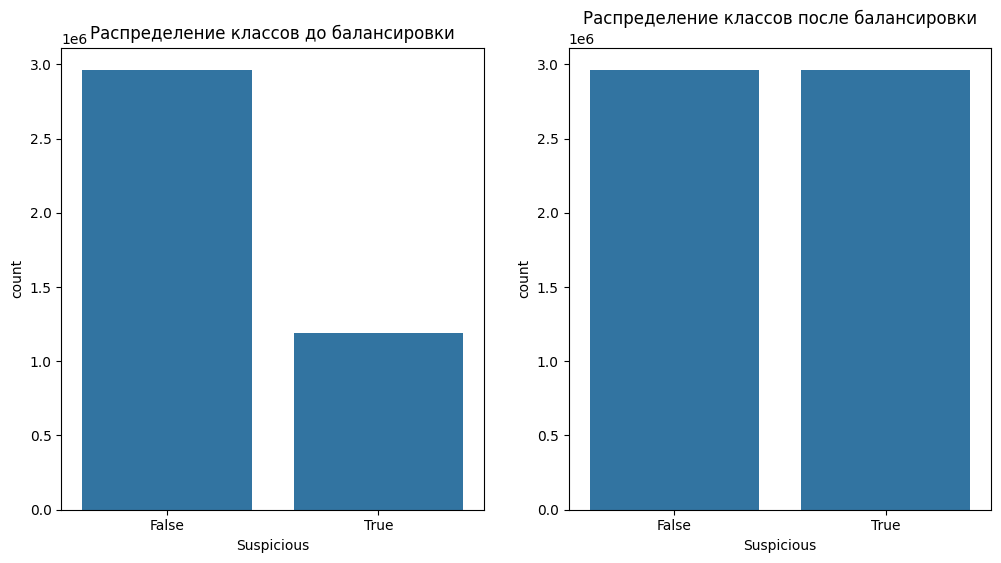

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Распределение классов до балансировки
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Suspicious', data=data)
plt.title('Распределение классов до балансировки')

# Распределение классов после балансировки
plt.subplot(1, 2, 2)
sns.countplot(x=y_balanced)
plt.title('Распределение классов после балансировки')

plt.show()


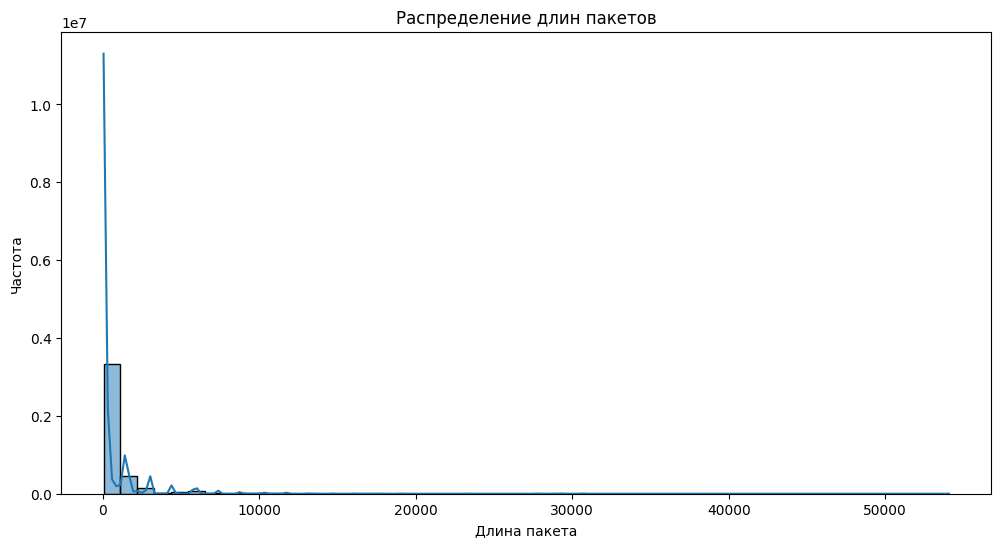

In [4]:
plt.figure(figsize=(12, 6))
sns.histplot(data['Length'], bins=50, kde=True)
plt.title('Распределение длин пакетов')
plt.xlabel('Длина пакета')
plt.ylabel('Частота')
plt.show()


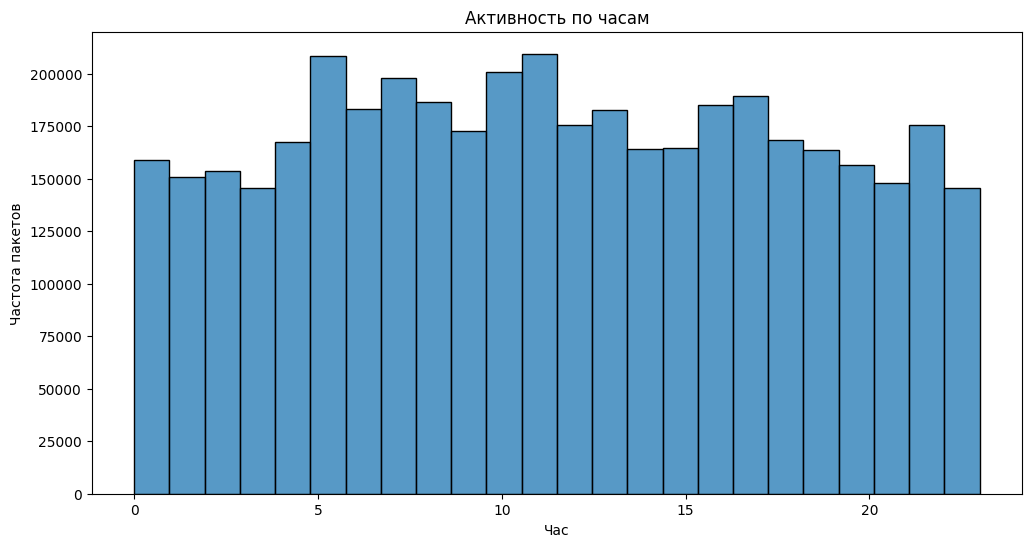

In [5]:
plt.figure(figsize=(12, 6))
sns.histplot(data['Time'].dt.hour, bins=24, kde=False)
plt.title('Активность по часам')
plt.xlabel('Час')
plt.ylabel('Частота пакетов')
plt.show()


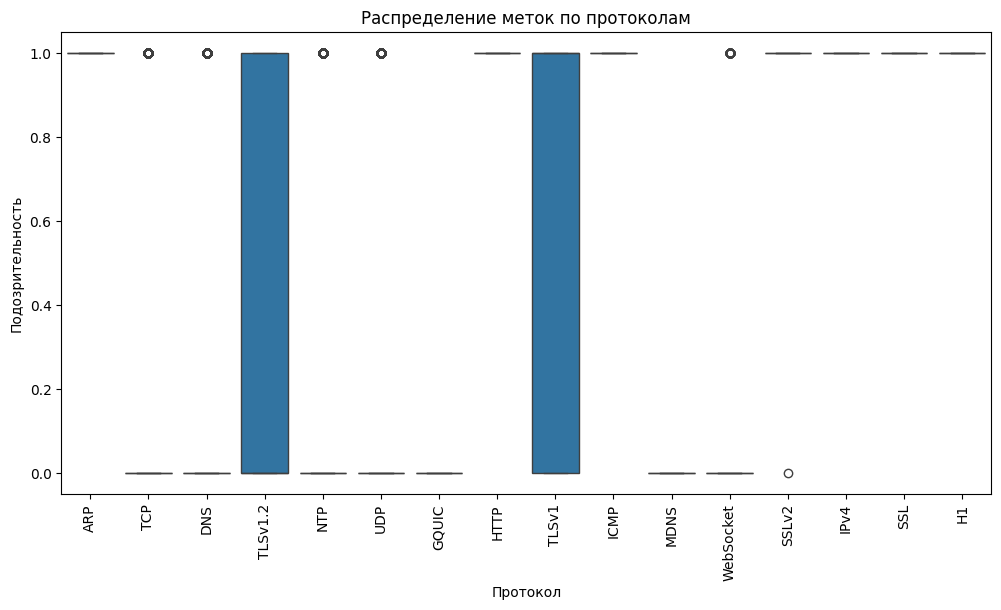

In [6]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Protocol', y='Suspicious', data=data)
plt.title('Распределение меток по протоколам')
plt.xlabel('Протокол')
plt.ylabel('Подозрительность')
plt.xticks(rotation=90)
plt.show()


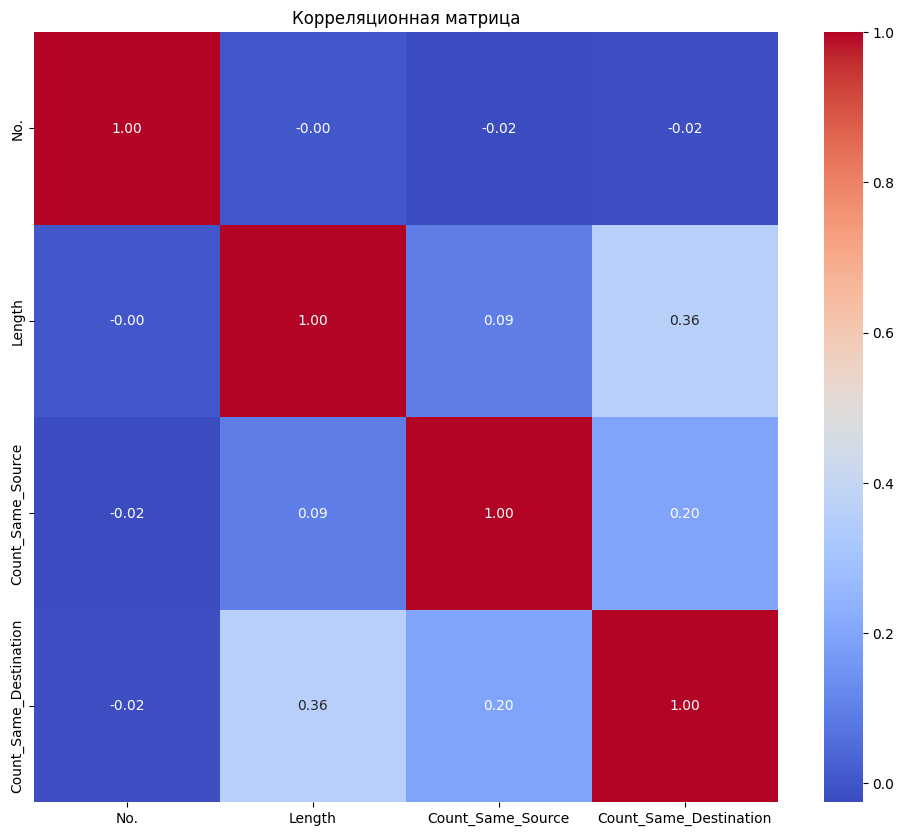

In [7]:
# Выберем только числовые столбцы для корреляционной матрицы
numerical_columns = data.select_dtypes(include=[np.number]).columns
correlation_matrix = data[numerical_columns].corr()

# Построим корреляционную матрицу
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()


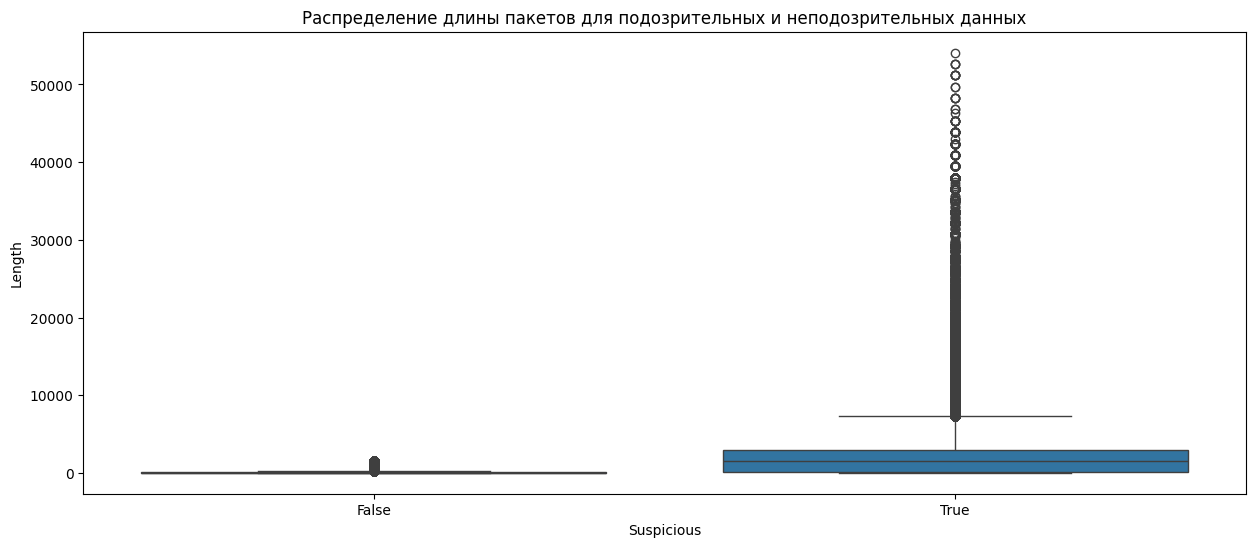

In [9]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='Suspicious', y='Length', data=data)
plt.title('Распределение длины пакетов для подозрительных и неподозрительных данных')
plt.show()


Обучение модели Logistic Regression...
Logistic Regression - Время обучения: 23.58 секунд
Logistic Regression:
              precision    recall  f1-score   support

       False       0.85      0.83      0.84    888707
        True       0.83      0.85      0.84    889549

    accuracy                           0.84   1778256
   macro avg       0.84      0.84      0.84   1778256
weighted avg       0.84      0.84      0.84   1778256

Точность: 0.8417230140092316


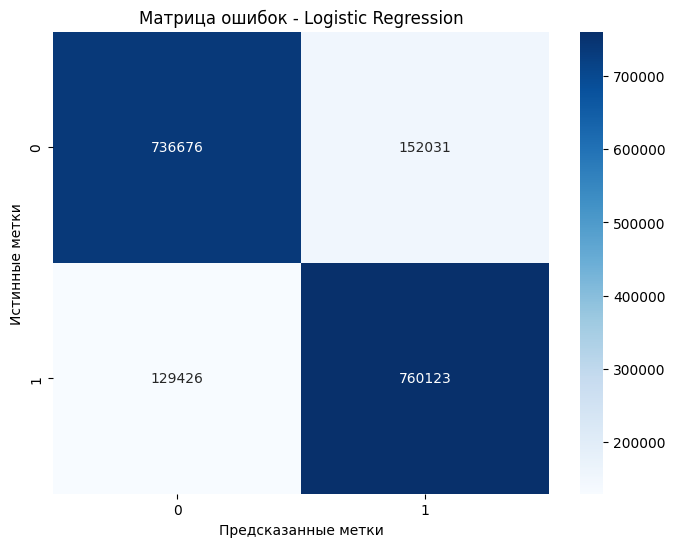

Обучение модели LinearSVC...
LinearSVC - Время обучения: 19.48 секунд
LinearSVC:
              precision    recall  f1-score   support

       False       0.85      0.83      0.84    888707
        True       0.83      0.86      0.84    889549

    accuracy                           0.84   1778256
   macro avg       0.84      0.84      0.84   1778256
weighted avg       0.84      0.84      0.84   1778256

Точность: 0.8422325019569735


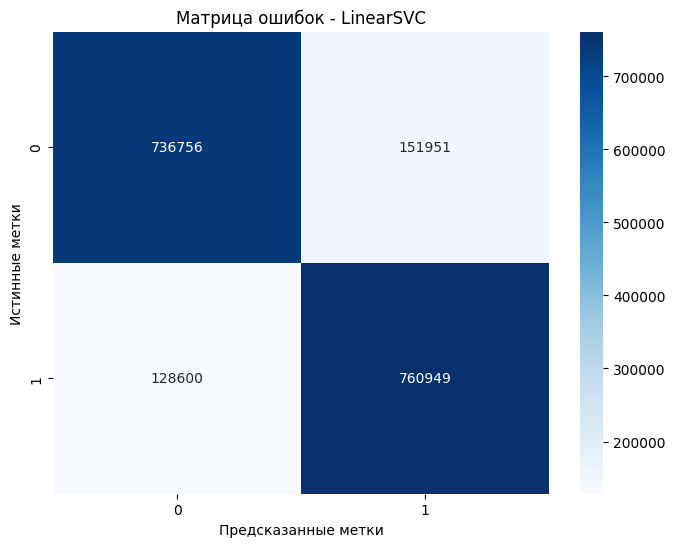

Обучение модели RidgeClassifier...


C:\Users\Alexandr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=9.6938e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


RidgeClassifier - Время обучения: 2.62 секунд
RidgeClassifier:
              precision    recall  f1-score   support

       False       0.96      1.00      0.98    888707
        True       1.00      0.96      0.98    889549

    accuracy                           0.98   1778256
   macro avg       0.98      0.98      0.98   1778256
weighted avg       0.98      0.98      0.98   1778256

Точность: 0.9780110400302319


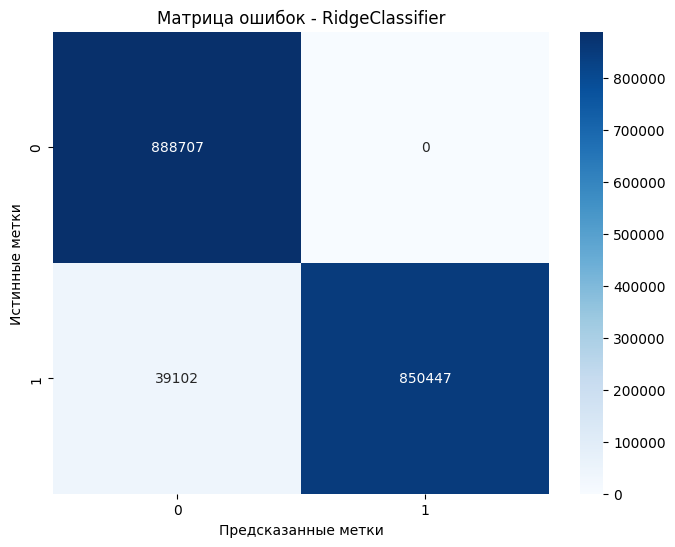

Обучение модели GaussianNB...
GaussianNB - Время обучения: 2.73 секунд
GaussianNB:
              precision    recall  f1-score   support

       False       0.71      0.92      0.80    888707
        True       0.88      0.62      0.73    889549

    accuracy                           0.77   1778256
   macro avg       0.80      0.77      0.77   1778256
weighted avg       0.80      0.77      0.77   1778256

Точность: 0.7701360209103751


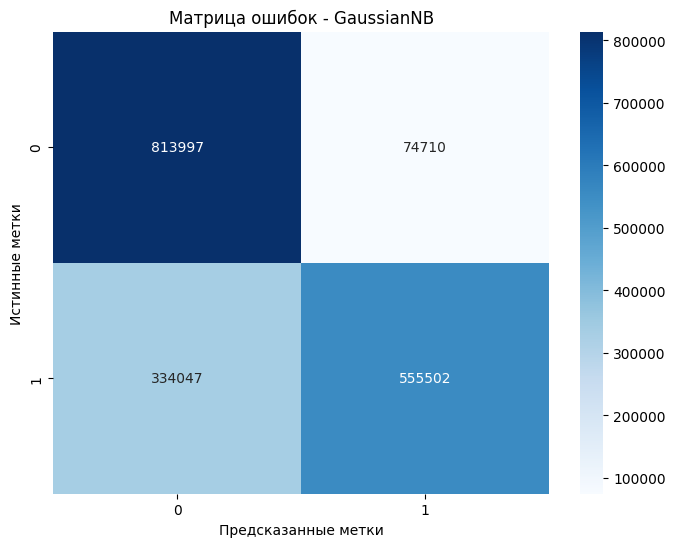

Обучение модели Decision Tree Classifier...
Decision Tree Classifier - Время обучения: 34.26 секунд
Decision Tree Classifier:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    888707
        True       1.00      1.00      1.00    889549

    accuracy                           1.00   1778256
   macro avg       1.00      1.00      1.00   1778256
weighted avg       1.00      1.00      1.00   1778256

Точность: 0.999686771758397


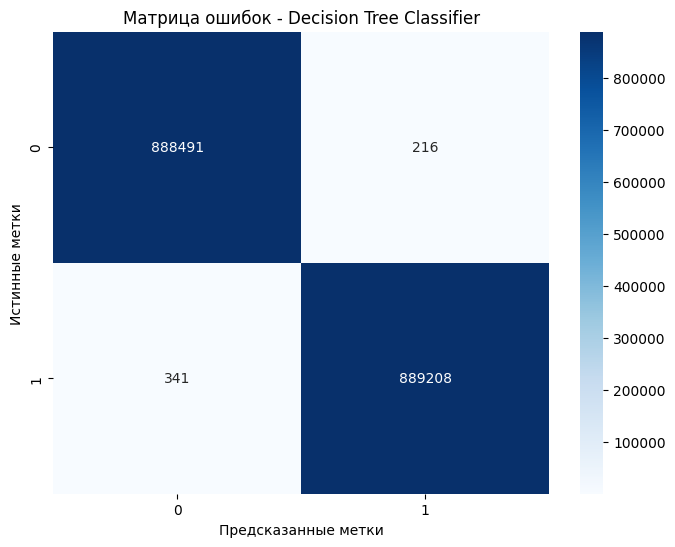

Все модели успешно сохранены!


In [13]:
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Словарь моделей
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'LinearSVC': LinearSVC(dual=False, random_state=42),
    'RidgeClassifier': RidgeClassifier(random_state=42),
    'GaussianNB': GaussianNB(),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=42)
}

# Обучим и оценим модели
for name, model in models.items():
    print(f"Обучение модели {name}...")
    
    start_time = time.time()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    end_time = time.time()
    
    print(f"{name} - Время обучения: {end_time - start_time:.2f} секунд")
    print(f"{name}:")
    print(classification_report(y_test, y_pred))
    print("Точность:", accuracy_score(y_test, y_pred))
    
    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Матрица ошибок - {name}")
    plt.ylabel('Истинные метки')
    plt.xlabel('Предсказанные метки')
    plt.show()

# Сохранение моделей
import joblib

# Сохранение моделей
joblib.dump(models['Logistic Regression'], 'logistic_regression_model.pkl')
joblib.dump(models['LinearSVC'], 'linear_svc_model.pkl')
joblib.dump(models['RidgeClassifier'], 'ridge_classifier_model.pkl')
joblib.dump(models['GaussianNB'], 'gaussian_nb_model.pkl')
joblib.dump(models['Decision Tree Classifier'], 'decision_tree_classifier_model.pkl')

print("Все модели успешно сохранены!")


In [14]:
import pandas as pd

results = {
    'Model': ['Logistic Regression', 'LinearSVC', 'RidgeClassifier', 'GaussianNB', 'Decision Tree Classifier'],
    'Accuracy': [0.8417230140092316, 0.8422325019569735, 0.9780110400302319, 0.7701360209103751, 0.999686771758397],
    'Precision': [0.83, 0.83, 0.96, 0.71, 1.00],
    'Recall': [0.85, 0.86, 1.00, 0.92, 1.00],
    'F1-Score': [0.84, 0.84, 0.98, 0.80, 1.00]
}

results_df = pd.DataFrame(results)
print(results_df)


                      Model  Accuracy  Precision  Recall  F1-Score
0       Logistic Regression  0.841723       0.83    0.85      0.84
1                 LinearSVC  0.842233       0.83    0.86      0.84
2           RidgeClassifier  0.978011       0.96    1.00      0.98
3                GaussianNB  0.770136       0.71    0.92      0.80
4  Decision Tree Classifier  0.999687       1.00    1.00      1.00


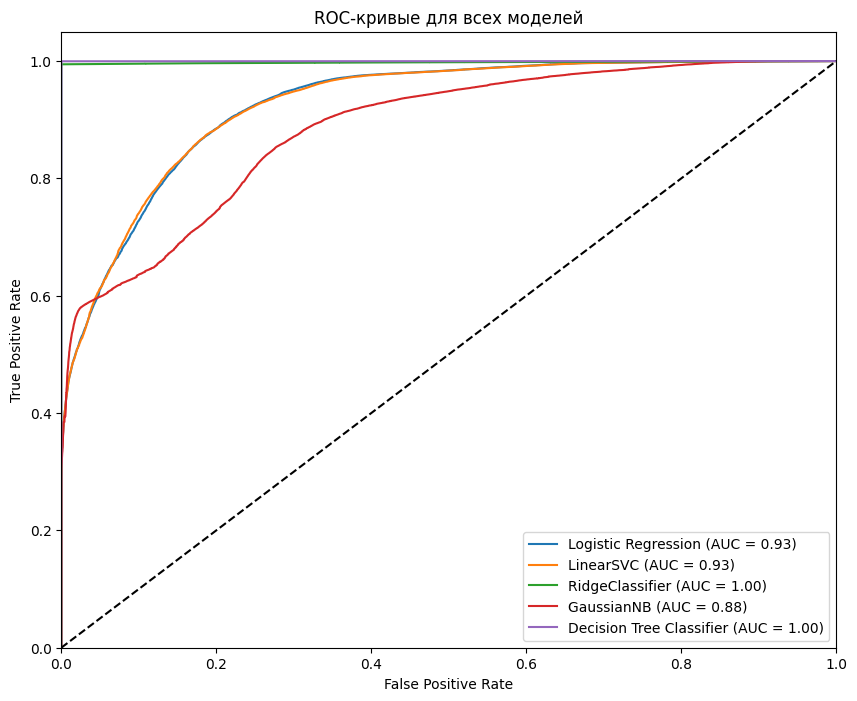

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для всех моделей')
plt.legend(loc='lower right')
plt.show()


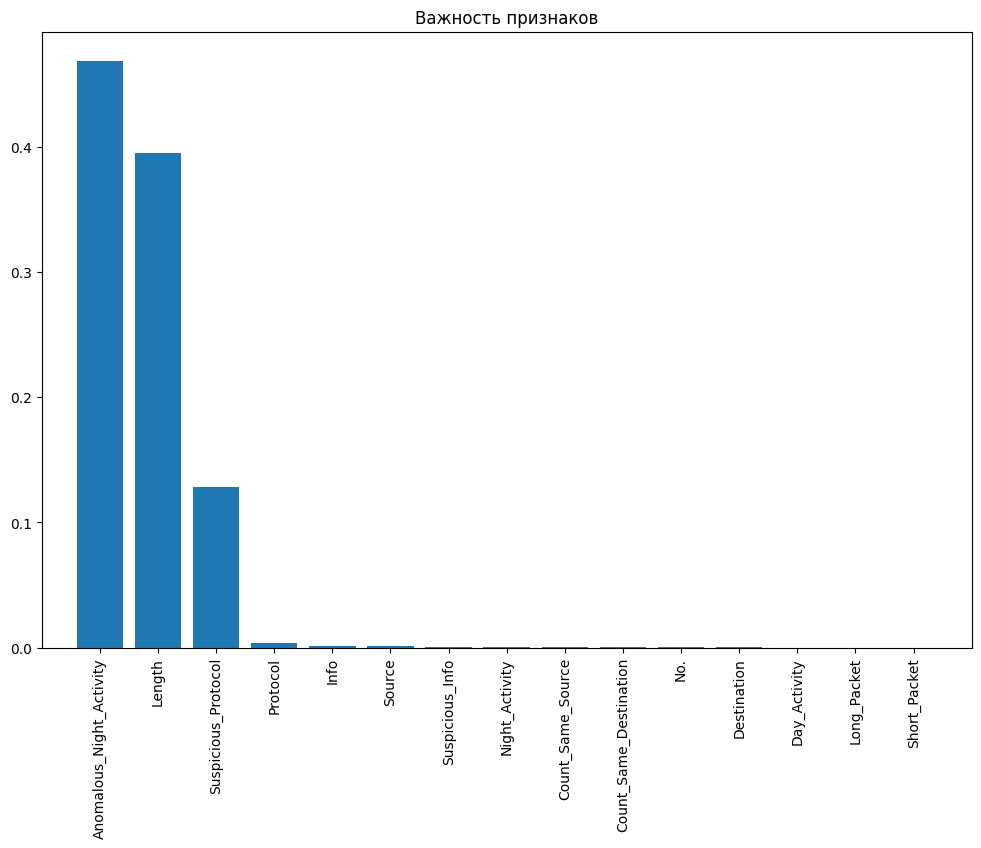

In [16]:
importances = models['Decision Tree Classifier'].feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Важность признаков')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


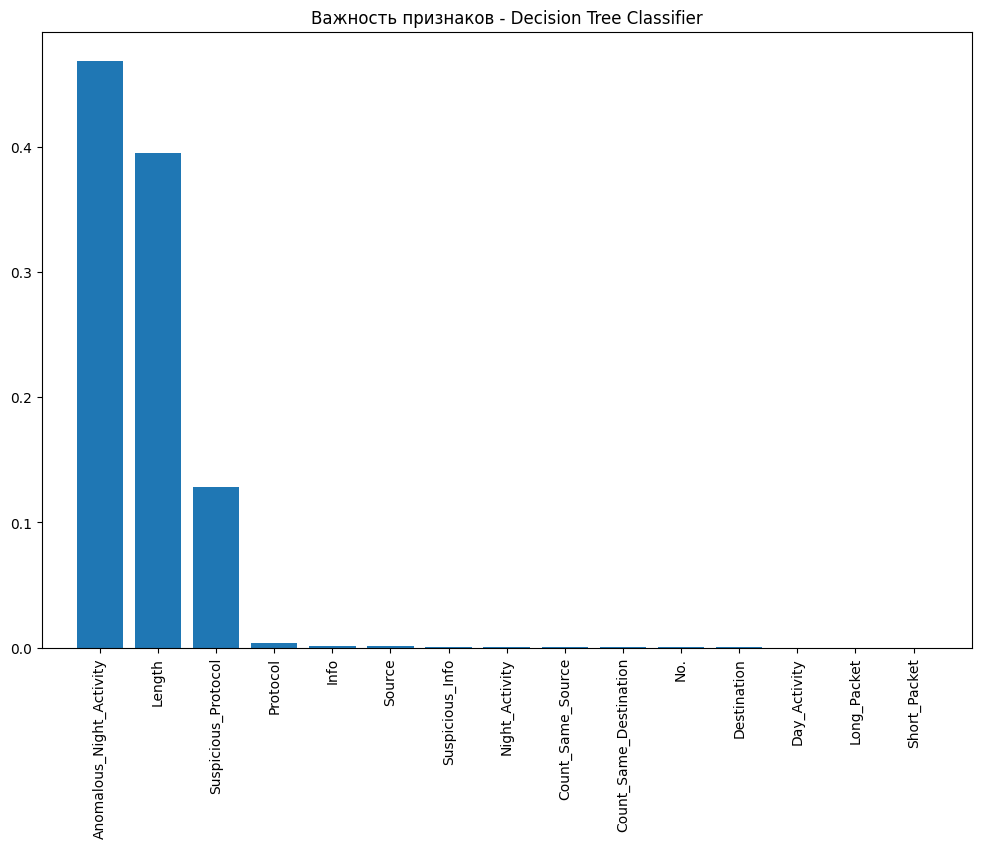

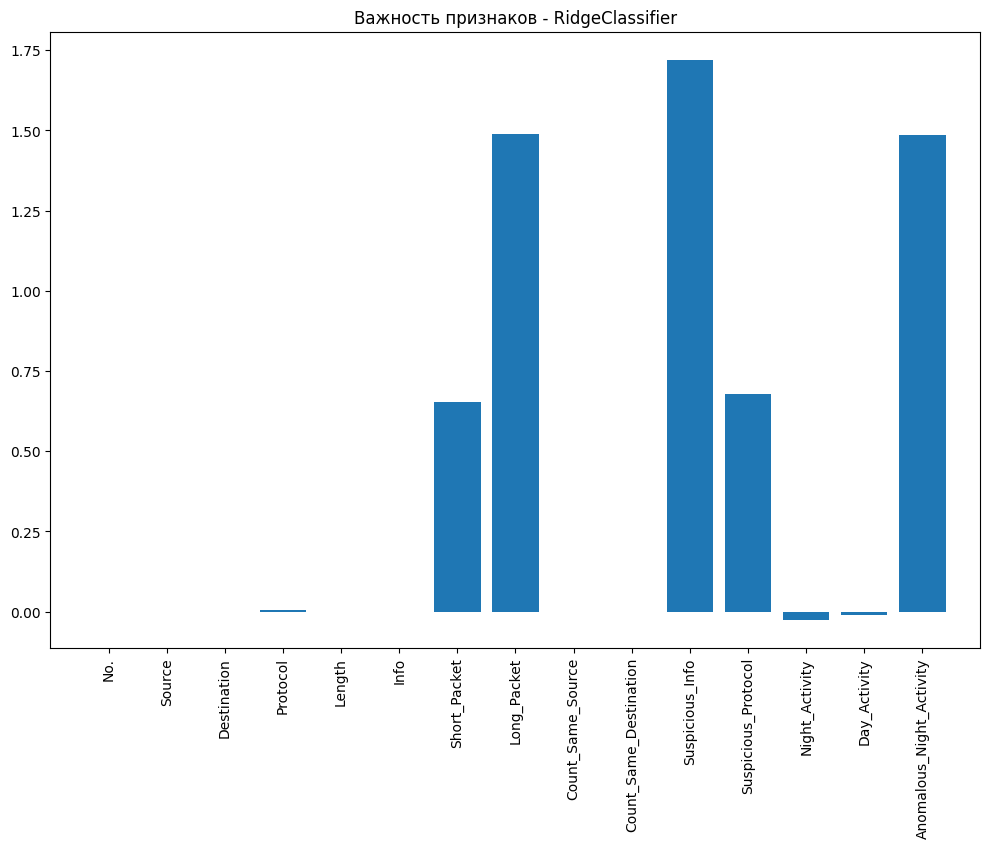

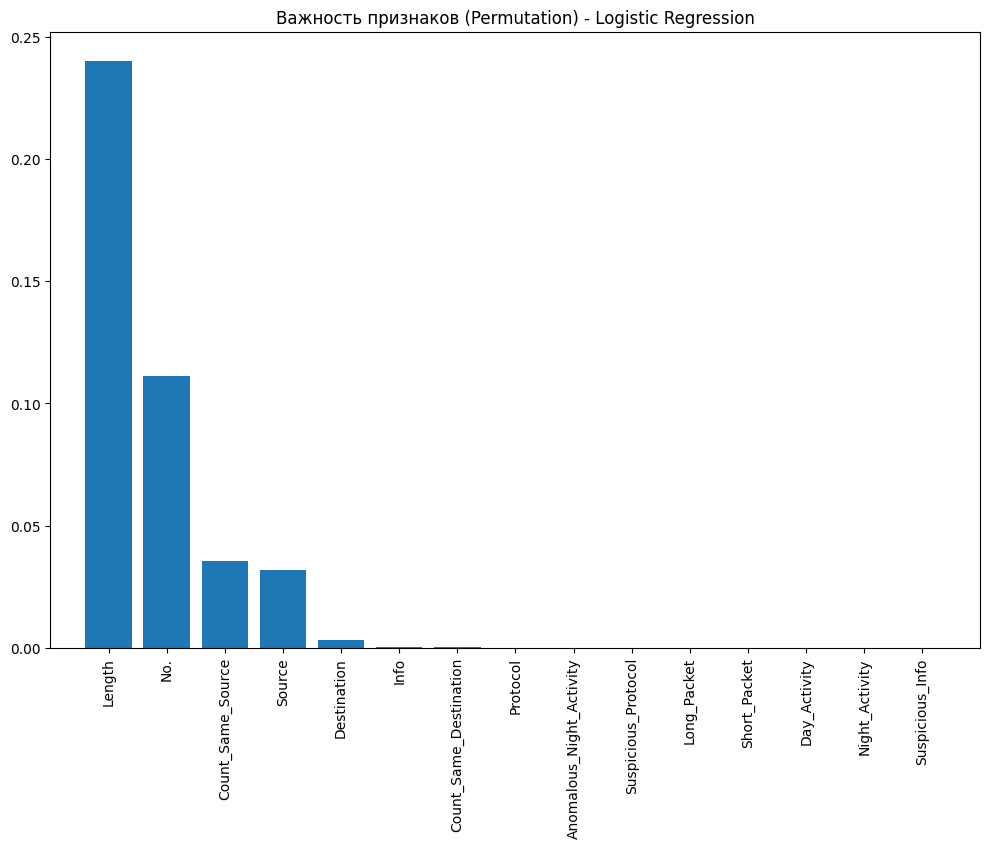

KeyboardInterrupt: 

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Функция для отображения важности признаков
def plot_feature_importance(model, model_name, feature_names):
    importances = model.feature_importances_ if hasattr(model, 'feature_importances_') else None
    if importances is None:
        return
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title(f'Важность признаков - {model_name}')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.show()

# Названия признаков
feature_names = X.columns

# Важность признаков для Decision Tree
plot_feature_importance(models['Decision Tree Classifier'], 'Decision Tree Classifier', feature_names)

# Важность признаков для RidgeClassifier через коэффициенты регрессии
if 'RidgeClassifier' in models:
    ridge_importances = models['RidgeClassifier'].coef_[0]
    plt.figure(figsize=(12, 8))
    plt.title('Важность признаков - RidgeClassifier')
    plt.bar(range(len(ridge_importances)), ridge_importances, align='center')
    plt.xticks(range(len(ridge_importances)), feature_names, rotation=90)
    plt.xlim([-1, len(ridge_importances)])
    plt.show()

# Пример использования Permutation Importance для моделей без встроенной важности признаков
from sklearn.inspection import permutation_importance

for name, model in models.items():
    if name not in ['Decision Tree Classifier', 'RidgeClassifier']:
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
        perm_importances = perm_importance.importances_mean
        indices = np.argsort(perm_importances)[::-1]
        
        plt.figure(figsize=(12, 8))
        plt.title(f'Важность признаков (Permutation) - {name}')
        plt.bar(range(len(perm_importances)), perm_importances[indices], align='center')
        plt.xticks(range(len(perm_importances)), feature_names[indices], rotation=90)
        plt.xlim([-1, len(perm_importances)])
        plt.show()


In [18]:
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder

# Загрузка обученных моделей
log_reg = joblib.load('logistic_regression_model.pkl')
svc = joblib.load('linear_svc_model.pkl')
ridge = joblib.load('ridge_classifier_model.pkl')
nb = joblib.load('gaussian_nb_model.pkl')
tree_clf = joblib.load('decision_tree_classifier_model.pkl')

# Загрузим новый датасет
new_data = pd.read_csv("new_dataset.csv")

# Преобразуем столбец времени в datetime, учитывая формат данных
new_data['Time'] = pd.to_datetime(new_data['Time'], format='%Y-%m-%d %H:%M:%S')

# Добавим признаки, используемые при обучении моделей
new_data['Short_Packet'] = new_data['Length'] < 50
new_data['Long_Packet'] = new_data['Length'] > 1500

time_window = '1T'  # 1 минута
new_data['Time_Rounded'] = new_data['Time'].dt.floor(time_window)
new_data['Count_Same_Source'] = new_data.groupby(['Source', 'Time_Rounded'])['Time'].transform('count')
new_data['Count_Same_Destination'] = new_data.groupby(['Destination', 'Time_Rounded'])['Time'].transform('count')

new_data['Info'] = new_data['Info'].fillna('')
suspicious_tlds = ['.xyz', '.top', '.info', '.club', '.work']
new_data['Suspicious_Info'] = new_data['Info'].apply(lambda x: any(tld in x for tld in suspicious_tlds))

suspicious_protocols = ['LDAP', 'SMTP', 'ICMP', 'ARP', 'TFTP', 'HTTP', 'HTTPS', 'SMB', 'RDP', 'Telnet']
new_data['Suspicious_Protocol'] = new_data['Protocol'].isin(suspicious_protocols)

new_data['Night_Activity'] = new_data['Time'].dt.hour.apply(lambda x: x >= 0 and x <= 6)
new_data['Day_Activity'] = new_data['Time'].dt.hour.apply(lambda x: x > 6 and x <= 18)
day_activity_mean = new_data[new_data['Day_Activity']].groupby('Source')['Count_Same_Source'].mean()
new_data['Anomalous_Night_Activity'] = new_data.apply(lambda row: row['Count_Same_Source'] > day_activity_mean.get(row['Source'], 0) if row['Night_Activity'] else False, axis=1)

new_data['Suspicious'] = (
    (new_data['Short_Packet']) |
    (new_data['Long_Packet']) |
    (new_data['Count_Same_Source'] > 10000) |
    (new_data['Count_Same_Destination'] > 10000) |
    (new_data['Suspicious_Info']) |
    (new_data['Suspicious_Protocol']) |
    (new_data['Anomalous_Night_Activity'])
)

# Исключим столбцы 'Suspicious', 'Time' и 'Time_Rounded' перед предсказанием
X_new = new_data.drop(columns=['Suspicious', 'Time', 'Time_Rounded'])

# Преобразуем категориальные признаки в числовые с помощью label encoding
label_encoders = {}
categorical_columns = ['Source', 'Destination', 'Protocol', 'Info']
for col in categorical_columns:
    le = LabelEncoder()
    X_new[col] = le.fit_transform(X_new[col].astype(str))
    label_encoders[col] = le

# Подсчитаем количество и процент подозрительных пакетов для каждой модели
models = {
    'Logistic Regression': log_reg,
    'LinearSVC': svc,
    'RidgeClassifier': ridge,
    'GaussianNB': nb,
    'Decision Tree Classifier': tree_clf
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_new)
    new_data[f'Suspicious_{name}'] = y_pred
    
    suspicious_count = sum(y_pred)
    total_count = len(y_pred)
    suspicious_percentage = (suspicious_count / total_count) * 100
    
    results[name] = {
        'Count': suspicious_count,
        'Percentage': suspicious_percentage
    }

# Выведем результаты
for name, result in results.items():
    print(f"Модель {name}:")
    print(f"Количество подозрительных пакетов: {result['Count']}")
    print(f"Процент подозрительных пакетов: {result['Percentage']:.2f}%")
    print()


Модель Logistic Regression:
Количество подозрительных пакетов: 1526404
Процент подозрительных пакетов: 36.73%

Модель LinearSVC:
Количество подозрительных пакетов: 1527236
Процент подозрительных пакетов: 36.75%

Модель RidgeClassifier:
Количество подозрительных пакетов: 1146451
Процент подозрительных пакетов: 27.58%

Модель GaussianNB:
Количество подозрительных пакетов: 996637
Процент подозрительных пакетов: 23.98%

Модель Decision Tree Classifier:
Количество подозрительных пакетов: 1212200
Процент подозрительных пакетов: 29.17%



In [19]:
results_df = pd.DataFrame(results).T
results_df.index.name = 'Model'
print(results_df)


                              Count  Percentage
Model                                          
Logistic Regression       1526404.0   36.727003
LinearSVC                 1527236.0   36.747022
RidgeClassifier           1146451.0   27.584905
GaussianNB                 996637.0   23.980211
Decision Tree Classifier  1212200.0   29.166900


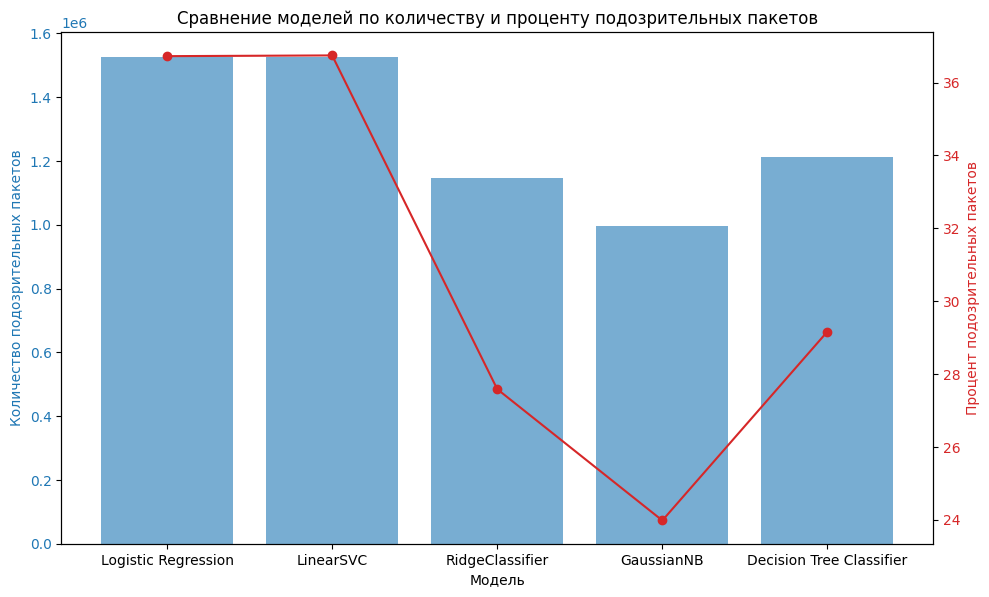

In [20]:
import matplotlib.pyplot as plt

# Построим графики
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Модель')
ax1.set_ylabel('Количество подозрительных пакетов', color=color)
ax1.bar(results_df.index, results_df['Count'], color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Процент подозрительных пакетов', color=color)
ax2.plot(results_df.index, results_df['Percentage'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Сравнение моделей по количеству и проценту подозрительных пакетов')
plt.show()


In [21]:
print("Сравнительный анализ моделей:")
for name, result in results.items():
    print(f"\nМодель: {name}")
    print(f"  - Количество подозрительных пакетов: {result['Count']}")
    print(f"  - Процент подозрительных пакетов: {result['Percentage']:.2f}%")


Сравнительный анализ моделей:

Модель: Logistic Regression
  - Количество подозрительных пакетов: 1526404
  - Процент подозрительных пакетов: 36.73%

Модель: LinearSVC
  - Количество подозрительных пакетов: 1527236
  - Процент подозрительных пакетов: 36.75%

Модель: RidgeClassifier
  - Количество подозрительных пакетов: 1146451
  - Процент подозрительных пакетов: 27.58%

Модель: GaussianNB
  - Количество подозрительных пакетов: 996637
  - Процент подозрительных пакетов: 23.98%

Модель: Decision Tree Classifier
  - Количество подозрительных пакетов: 1212200
  - Процент подозрительных пакетов: 29.17%


In [22]:
import pandas as pd

# Загрузка датасета
data = pd.read_csv("dataset.csv")

# Обзор первых 5 строк датасета
print(data.head())


   No.                 Time                 Source    Destination Protocol  \
0    1  2018-01-30 23:14:02  LCFCElectron_06:cb:e8      Broadcast      ARP   
1    2  2018-01-30 23:14:02          10.55.182.100   10.233.233.5      TCP   
2    3  2018-01-30 23:14:02           192.168.88.2  165.227.88.15      DNS   
3    4  2018-01-30 23:14:02          165.227.88.15   192.168.88.2      DNS   
4    5  2018-01-30 23:14:03           192.168.88.2  165.227.88.15      DNS   

   Length                                               Info  
0      42            Who has 10.55.100.1? Tell 10.55.100.197  
1      66  14291  >  80 [SYN] Seq=0 Win=64240 Len=0 MSS=1...  
2     103  Standard query 0xa7b9 TXT 6dde0175375169c68f.d...  
3     123  Standard query response 0xa7b9 TXT 6dde0175375...  
4     103  Standard query 0x40ac TXT 0b320175375169c68f.d...  
